##### Master Degree in Computer Science and Data Science for Economics

# Quick introduction to neural networks as functions approximators

### Alfio Ferrara

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import torch.nn as nn
import torch

## Define a function that we want to approximate

In [3]:
import matplotlib.pyplot as plt

In [4]:
f_x = lambda x: np.sin(x) - (x**2 / 40)

In [5]:
X = np.arange(-5, 5, .1)

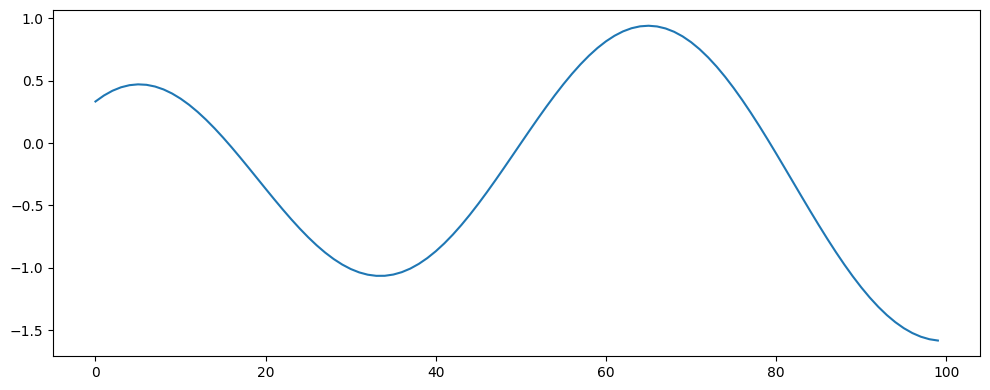

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(f_x(X))
plt.tight_layout()
plt.show()

## Use a NN to learn the function

In [7]:
class SigmoidNeuralNet(nn.Module):
    """Double-layer neural network with sigmoid activation."""
    
    def __init__(self, num_features, nodes=4):
        super().__init__()
        self.layer1  = nn.Linear(in_features=num_features, out_features=nodes)
        self.layer2  = nn.Linear(in_features=nodes, out_features=num_features)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        logits1 = self.layer1(inputs)
        activations = self.sigmoid(logits1)
        output = self.layer2(activations)
        return output

In [8]:
class ReluNeuralNet(nn.Module):
    """Double-layer neural network with Relu activation."""
    
    def __init__(self, num_features, nodes=4):
        super().__init__()
        self.layer1  = nn.Linear(in_features=num_features, out_features=nodes)
        self.layer2  = nn.Linear(in_features=nodes, out_features=num_features)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        logits1 = self.layer1(inputs)
        activations = self.relu(logits1)
        output = self.layer2(activations)
        return output

In [27]:
inputs = torch.randint(-10, 10, (2000, 1)).float()
num_features = inputs.size(-1)
model = SigmoidNeuralNet(num_features, nodes=4)
#model = ReluNeuralNet(num_features, nodes=4)

In [28]:
inputs

tensor([[  0.],
        [  8.],
        [ -2.],
        ...,
        [  3.],
        [-10.],
        [  8.]])

In [29]:
prediction = model(inputs)

In [30]:
prediction

tensor([[-0.1341],
        [-0.0750],
        [-0.2381],
        ...,
        [-0.0711],
        [-0.2812],
        [-0.0750]], grad_fn=<AddmmBackward0>)

### Training

In [31]:
targets = f_x(inputs)

/var/folders/t2/dvy2q49d2vsc731h1cfy6dnr0000gn/T/ipykernel_4460/1164241505.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f_x = lambda x: np.sin(x) - (x**2 / 40)


In [32]:
targets

tensor([[ 0.0000],
        [-0.6106],
        [-1.0093],
        ...,
        [-0.0839],
        [-1.9560],
        [-0.6106]])

#### Loss function

In [33]:
from torch.nn import MSELoss

In [34]:
loss = MSELoss()
error = loss(prediction, targets)
error

tensor(1.3138, grad_fn=<MseLossBackward0>)

#### Optimizer for gradient descent

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

#### Data management

In [36]:
from torch.utils.data import Dataset, DataLoader

In [37]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.x = inputs
        self.y = targets
        
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [38]:
dataset = CustomDataset(inputs, targets)
dataset[1]

(tensor([8.]), tensor([-0.6106]))

**Dataloader**: Using a dataloader we can define how the network will read the data and how often parameters will be updated (batch approach)

In [39]:
dataloader = DataLoader(dataset, batch_size=10, drop_last=False, shuffle=False)

In [40]:
for i, batch in enumerate(dataloader):
    print(f"batch {i}: x: {batch[0]}, y: {batch[1]}")
    if i > 5:
        break

batch 0: x: tensor([[ 0.],
        [ 8.],
        [-2.],
        [ 3.],
        [ 8.],
        [-8.],
        [ 4.],
        [ 3.],
        [-2.],
        [-4.]]), y: tensor([[ 0.0000],
        [-0.6106],
        [-1.0093],
        [-0.0839],
        [-0.6106],
        [-2.5894],
        [-1.1568],
        [-0.0839],
        [-1.0093],
        [ 0.3568]])
batch 1: x: tensor([[-5.],
        [-4.],
        [-4.],
        [-8.],
        [ 7.],
        [ 8.],
        [ 0.],
        [-7.],
        [ 2.],
        [-1.]]), y: tensor([[ 0.3339],
        [ 0.3568],
        [ 0.3568],
        [-2.5894],
        [-0.5680],
        [-0.6106],
        [ 0.0000],
        [-1.8820],
        [ 0.8093],
        [-0.8665]])
batch 2: x: tensor([[ 6.],
        [ 8.],
        [-9.],
        [ 9.],
        [-8.],
        [-9.],
        [ 6.],
        [-9.],
        [-3.],
        [ 9.]]), y: tensor([[-1.1794],
        [-0.6106],
        [-2.4371],
        [-1.6129],
        [-2.5894],
        [-2.4371],
   

In [41]:
dataloader = DataLoader(dataset, batch_size=10, drop_last=False, shuffle=False)

### Training routine

In [42]:
epochs = 500

mean_error = []
predictions = []

run = list(range(epochs))

for epoch in tqdm(run):
    errors = []
    for batch in dataloader:
        # step 0: get the data and the correct target
        features, target = batch
        # step 1: use the model for prediction (forward pass)
        y_pred = model(features)
        # step 2: measure the error by comparing the predictions to the expected outputs
        error = loss(y_pred, target)
        # step 3: backprop the loss signal through the graph, notifying each parameter of its gradient
        error.backward()
        # step 4: update model parameters using the gradient
        optimizer.step() 
        # step 5: clear the previously computed gradients stored inside the model
        model.zero_grad()
        # step 6: reporting
        errors.append(error.item())
    mean_error.append(np.array(errors).mean())
    prediction_on_target = model(torch.tensor(X.reshape(-1, 1)).float()).detach().numpy().ravel()
    predictions.append(prediction_on_target)

  0%|          | 0/500 [00:00<?, ?it/s]

### Learning process

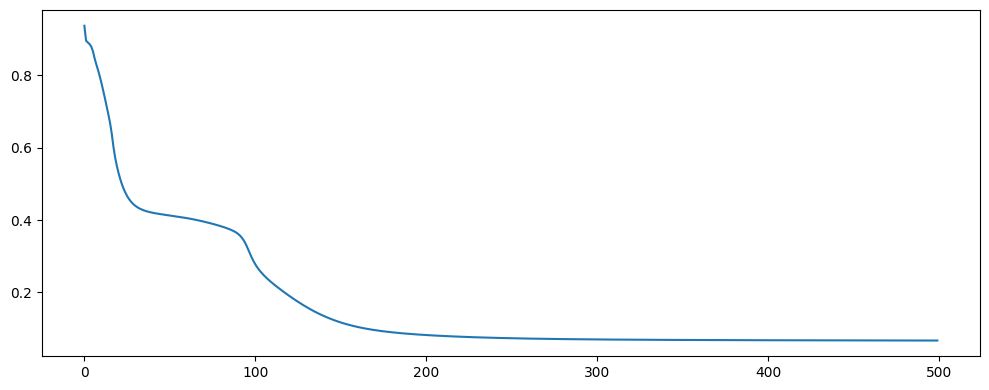

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(mean_error)
plt.tight_layout()
plt.show()

### Fit procedure

In [44]:
from IPython.display import clear_output

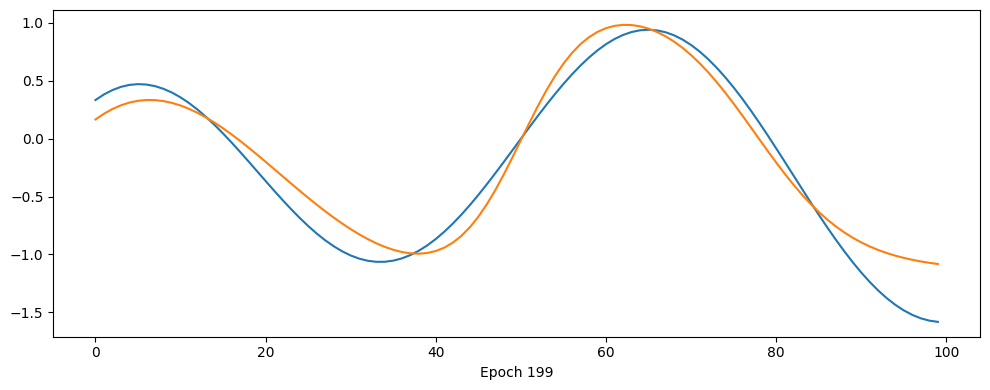

In [45]:
for i, y_pred in enumerate(predictions[:200]):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(f_x(X))
    ax.plot(y_pred)
    ax.set_xlabel('Epoch {}'.format(i))
    plt.tight_layout()
    plt.show()